<a href="https://colab.research.google.com/github/Meenu1105/Meenu/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Saving data.csv to data (2).csv
🔍 Logistic Regression Accuracy: 0.50
              precision    recall  f1-score   support

        FAKE       1.00      0.17      0.29         6
        REAL       0.44      1.00      0.62         4

    accuracy                           0.50        10
   macro avg       0.72      0.58      0.45        10
weighted avg       0.78      0.50      0.42        10

🔍 Passive Aggressive Accuracy: 0.90
              precision    recall  f1-score   support

        FAKE       1.00      0.83      0.91         6
        REAL       0.80      1.00      0.89         4

    accuracy                           0.90        10
   macro avg       0.90      0.92      0.90        10
weighted avg       0.92      0.90      0.90        10

🔍 Random Forest Accuracy: 0.50
              precision    recall  f1-score   support

        FAKE       1.00      0.17      0.29         6
        REAL       0.44      1.00      0.62         4

    accuracy                           0.50   

<ipython-input-3-6869d48d4bc2>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accs.keys()), y=list(accs.values()), palette='viridis')


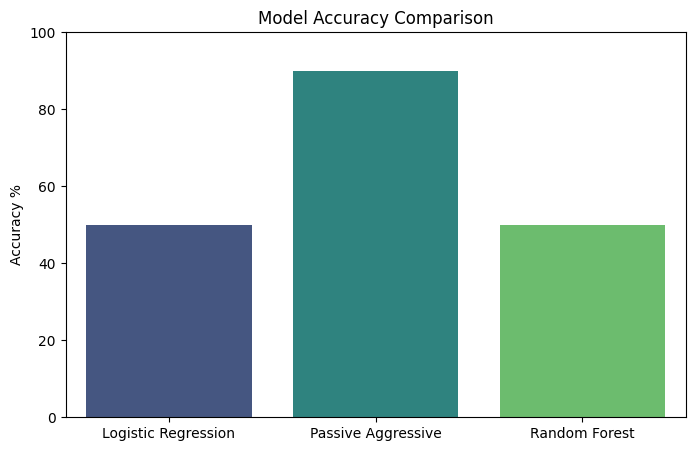

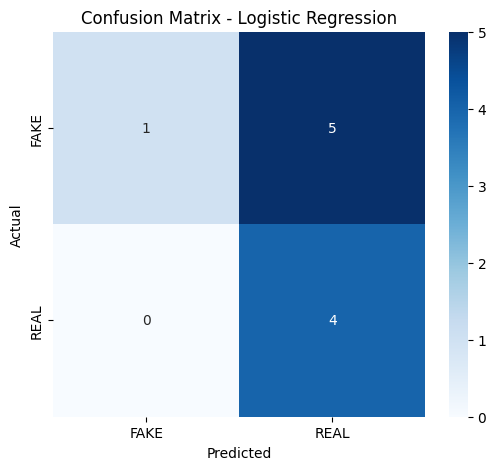

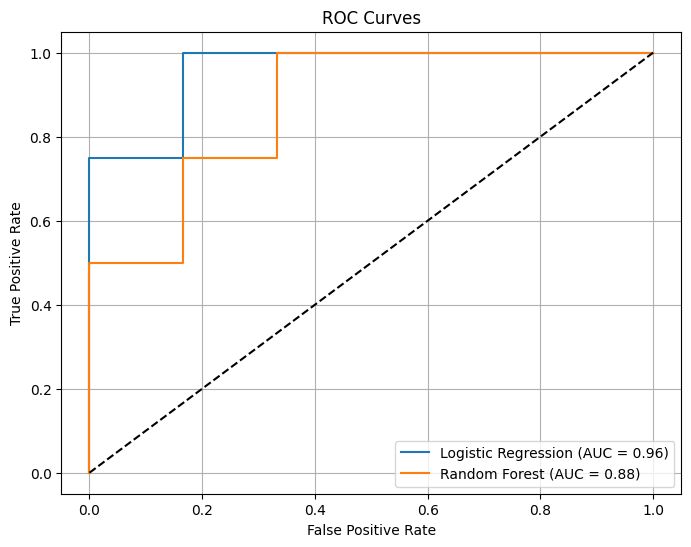

📰 Enter a news article: UN Climate Summit concludes with nations pledging to cut carbon emissions by 50%.

📢 This news is: REAL
📊 Confidence: 62.28%


<ipython-input-3-6869d48d4bc2>:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accs.keys()), y=list(accs.values()), palette='viridis')


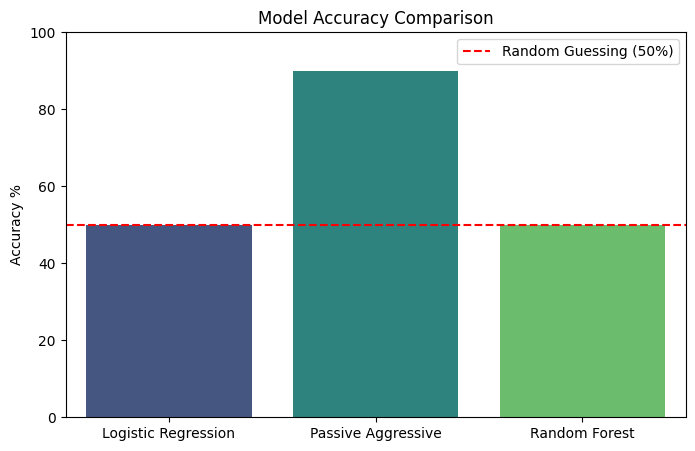

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!pip install nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from google.colab import files
uploaded = files.upload()
try:
    df = pd.read_csv('data.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv('data.csv', encoding='ISO-8859-1')
except Exception as e:
    print(f"An error occurred: {e}")

df = df[['text', 'label']].dropna()
df.head()



stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', str(text))
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['clean_text'] = df['text'].apply(clean_text)

X = df['clean_text']
y = df['label']

tfidf = TfidfVectorizer(max_df=0.7)
X_vec = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(),
    "Passive Aggressive": PassiveAggressiveClassifier(max_iter=100),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {
        "model": model,
        "accuracy": acc,
        "y_pred": y_pred,
        "report": classification_report(y_test, y_pred, output_dict=True),
        "confusion": confusion_matrix(y_test, y_pred)
    }
    print(f"🔍 {name} Accuracy: {acc:.2f}")
    print(classification_report(y_test, y_pred))

plt.figure(figsize=(8,5))
accs = {k: round(v['accuracy'] * 100, 2) for k, v in results.items()}
sns.barplot(x=list(accs.keys()), y=list(accs.values()), palette='viridis')
plt.ylabel("Accuracy %")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 100)
plt.show()

best_model = results['Logistic Regression']['model']
y_pred = results['Logistic Regression']['y_pred']
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE','REAL'], yticklabels=['FAKE','REAL'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(8, 6))

for name, r in results.items():
    model = r['model']
    if hasattr(model, "predict_proba"):
        # Get the predicted probabilities for the positive class
        probs = model.predict_proba(X_test)[:, 1]
        # Convert labels to binary (1 for REAL, 0 for FAKE)
        y_bin = [1 if label == "REAL" else 0 for label in y_test]
        # Calculate the false positive rate and true positive rate
        fpr, tpr, _ = roc_curve(y_bin, probs)
        # Calculate the AUC (Area Under the Curve)
        auc = roc_auc_score(y_bin, probs)
        # Plot the ROC curve
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

# Plot the diagonal line (no discrimination)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

def predict_news(news_text, model):
    cleaned = clean_text(news_text)
    vector = tfidf.transform([cleaned])
    pred = model.predict(vector)[0]
    prob = model.predict_proba(vector)[0].max() * 100 if hasattr(model, "predict_proba") else "N/A"
    return pred, prob

user_input = input("📰 Enter a news article: ")
result, confidence = predict_news(user_input, best_model)

print(f"\n📢 This news is: {result}")
if confidence != "N/A":
    print(f"📊 Confidence: {confidence:.2f}%")

plt.figure(figsize=(8, 5))
accs = {k: round(v['accuracy'] * 100, 2) for k, v in results.items()}
sns.barplot(x=list(accs.keys()), y=list(accs.values()), palette='viridis')
plt.ylabel("Accuracy %")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 100)
plt.axhline(y=50, color='r', linestyle='--', label='Random Guessing (50%)')  # Optional: Add a line for random guessing
plt.legend()
plt.show()

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
import joblib

# Load your dataset
df = pd.read_csv('data.csv', encoding='ISO-8859-1')

# Preprocess text and labels
X = df['text']
y = df['label']

# Vectorize the text using TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)
X_tfidf = tfidf.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train your model
model = PassiveAggressiveClassifier(max_iter=50)
model.fit(X_train, y_train)

# ✅ Save the model and vectorizer TOGETHER
joblib.dump(model, 'model.pkl')
joblib.dump(tfidf, 'vectorizer.pkl')


from google.colab import files



def predict_news(news_text, model, vectorizer):
    cleaned = clean_text(news_text)
    vector = vectorizer.transform([cleaned])
    prediction = model.predict(vector)[0]

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(vector)[0]
        confidence = np.max(proba) * 100
    else:
        confidence = "N/A"

    return prediction, confidence


import joblib
import numpy as np
from sklearn.metrics import accuracy_score



# Reload and clean your data to get accuracy
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', str(text))
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

# Load and prepare the dataset (again, for accuracy)
df = pd.read_csv('data.csv', encoding='ISO-8859-1')
df = df[['text', 'label']].dropna()
df['clean_text'] = df['text'].apply(clean_text)

X = vectorizer.transform(df['clean_text'])
y = df['label']

# Get overall accuracy of the model
y_pred = model.predict(X)
accuracy = accuracy_score(y, y_pred) * 100

# ✅ Prediction Function
def predict_news(news_text, model, vectorizer):
    cleaned = clean_text(news_text)
    vector = vectorizer.transform([cleaned])
    prediction = model.predict(vector)[0]

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(vector)[0]
        confidence = np.max(proba) * 100
    else:
        confidence = "N/A"

    return prediction, confidence

# ✅ Get user input and print everything
news_input = input("📰 Enter a news article: ")
result, confidence = predict_news(news_input, model, vectorizer)

print(f"\n📢 This news is: {result.upper()} ({confidence:.1f}% confidence)")
print(f"✅ Model Accuracy on dataset: {accuracy:.2f}%")